Hi, here is the code of the non-optional excercise 4. While the first two code snippets provide some useful information, the third code snippet is the main code that implements the the algorithms of the exercise.

Q-Learning and sg-Sarsa with one hot encoding with stepsize 1

Results for Q-Learning:


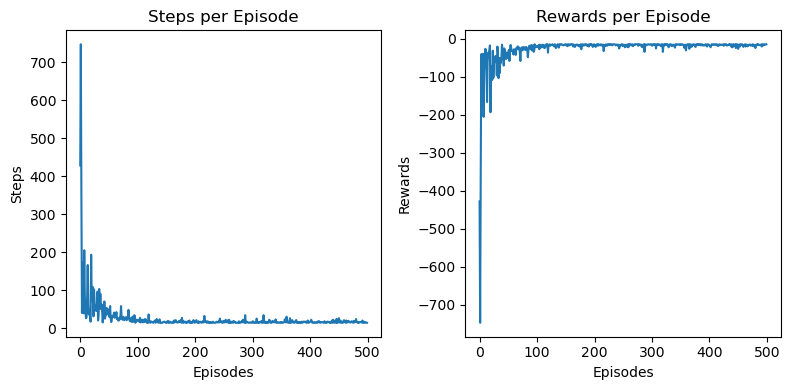

Results for Semi-Gradient SARSA:


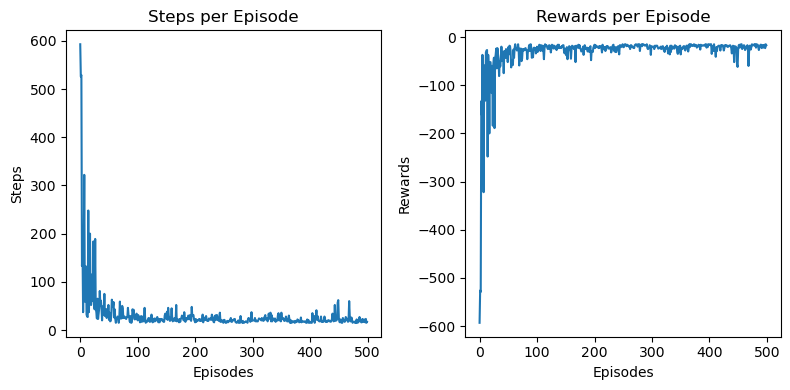

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Windy Grid World Environment
class WindyGridWorld:
    def __init__(self, rows, cols, wind_strength, start, goal):
        self.rows = rows
        self.cols = cols
        self.wind_strength = wind_strength
        self.start = start
        self.goal = goal
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Right, Down, Left, Up
        self.state = start

    def reset(self):
        self.state = self.start
        return self.state

    def step(self, action):
        row, col = self.state
        d_row, d_col = self.actions[action]

        # Apply wind
        wind = self.wind_strength[col]
        row = max(0, min(self.rows - 1, row - wind))

        # Apply action
        new_row = max(0, min(self.rows - 1, row + d_row))
        new_col = max(0, min(self.cols - 1, col + d_col))

        self.state = (new_row, new_col)
        reward = -1
        done = self.state == self.goal
        return self.state, reward, done

# Agent
class Agent:
    def __init__(self, env, alpha=0.5, epsilon=0.1, gamma=1.0):
        self.env = env
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.q_table = np.zeros((env.rows, env.cols, len(env.actions)))

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(len(self.env.actions))
        row, col = state
        return np.argmax(self.q_table[row, col])

    def update(self, state, action, reward, next_state):
        row, col = state
        next_row, next_col = next_state
        best_next_action = np.argmax(self.q_table[next_row, next_col])
        td_target = reward + self.gamma * self.q_table[next_row, next_col, best_next_action]
        td_error = td_target - self.q_table[row, col, action]
        self.q_table[row, col, action] += self.alpha * td_error

# Semi-Gradient SARSA Agent
class SemiGradientSARSA:
    def __init__(self, env, alpha=0.5, epsilon=0.1, gamma=1.0):
        self.env = env
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.theta = np.zeros((env.rows * env.cols * len(env.actions)))

    def features(self, state, action):
        row, col = state
        feature_vector = np.zeros(self.env.rows * self.env.cols * len(self.env.actions))
        index = (row * self.env.cols + col) * len(self.env.actions) + action
        feature_vector[index] = 1
        return feature_vector

    def q_value(self, state, action):
        return np.dot(self.theta, self.features(state, action))

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(len(self.env.actions))
        q_values = [self.q_value(state, a) for a in range(len(self.env.actions))]
        return np.argmax(q_values)

    def update(self, state, action, reward, next_state, next_action):
        current_q = self.q_value(state, action)
        next_q = self.q_value(next_state, next_action)
        td_error = reward + self.gamma * next_q - current_q
        self.theta += self.alpha * td_error * self.features(state, action)

# Testing and Visualization
def train(env, agent, episodes, sarsa=False):
    steps_per_episode = []
    rewards_per_episode = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        steps = 0
        action = agent.choose_action(state)

        while True:
            next_state, reward, done = env.step(action)
            next_action = agent.choose_action(next_state) if sarsa else None

            if sarsa:
                agent.update(state, action, reward, next_state, next_action)
            else:
                agent.update(state, action, reward, next_state)

            state = next_state
            action = next_action if sarsa else agent.choose_action(next_state)
            total_reward += reward
            steps += 1

            if done:
                break

        steps_per_episode.append(steps)
        rewards_per_episode.append(total_reward)

    return steps_per_episode, rewards_per_episode

def plot_results(steps, rewards, env, agent):
    # Plot Steps per Episode
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(steps)
    plt.xlabel('Episodes')
    plt.ylabel('Steps')
    plt.title('Steps per Episode')

    # Plot Rewards per Episode
    plt.subplot(1, 3, 2)
    plt.plot(rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.title('Rewards per Episode')

    """# Visualize Policy
    plt.subplot(1, 3, 3)
    policy = np.zeros((env.rows, env.cols), dtype=int)
    for row in range(env.rows):
        for col in range(env.cols):
            q_values = [agent.q_value((row, col), a) for a in range(len(env.actions))]
            policy[row, col] = np.argmax(q_values)

    policy_arrows = np.array(['→', '↓', '←', '↑'])
    grid = np.full((env.rows, env.cols), ' ')

    for row in range(env.rows):
        for col in range(env.cols):
            if (row, col) == env.goal:
                grid[row, col] = 'G'
            else:
                grid[row, col] = policy_arrows[policy[row, col]]

    plt.table(cellText=grid, loc='center', cellLoc='center', bbox=[0, 0, 1, 1])
    plt.axis('off')
    plt.title('Final Policy')"""

    plt.tight_layout()
    plt.show()

# Main
if __name__ == "__main__":
    rows, cols = 7, 10
    wind_strength = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
    start = (3, 0)
    goal = (3, 7)

    env = WindyGridWorld(rows, cols, wind_strength, start, goal)

    # Train Q-Learning Agent
    q_agent = Agent(env)
    episodes = 500
    steps_q, rewards_q = train(env, q_agent, episodes)

    # Train Semi-Gradient SARSA Agent
    sarsa_agent = SemiGradientSARSA(env)
    steps_sarsa, rewards_sarsa = train(env, sarsa_agent, episodes, sarsa=True)

    # Plot results for Q-Learning
    print("Results for Q-Learning:")
    plot_results(steps_q, rewards_q, env, q_agent)

    # Plot results for Semi-Gradient SARSA
    print("Results for Semi-Gradient SARSA:")
    plot_results(steps_sarsa, rewards_sarsa, env, sarsa_agent)


Q-Learning and sg-Sarsa with a step distance based on a normal distribution (1,0.33) -> pretty noisy but (1,0.1) seems pretty good

Results for Q-Learning:


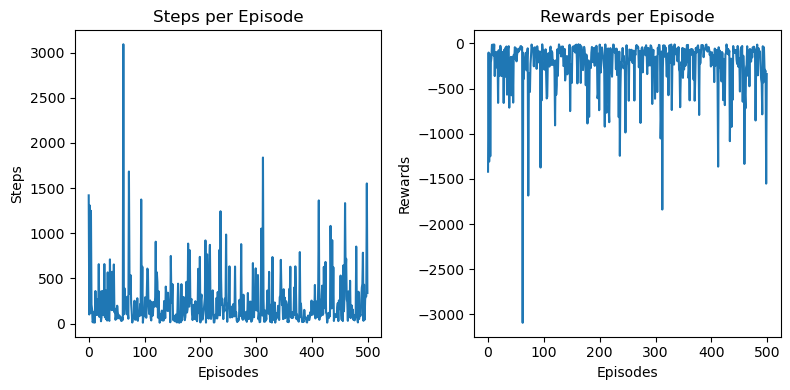

Results for Semi-Gradient SARSA:


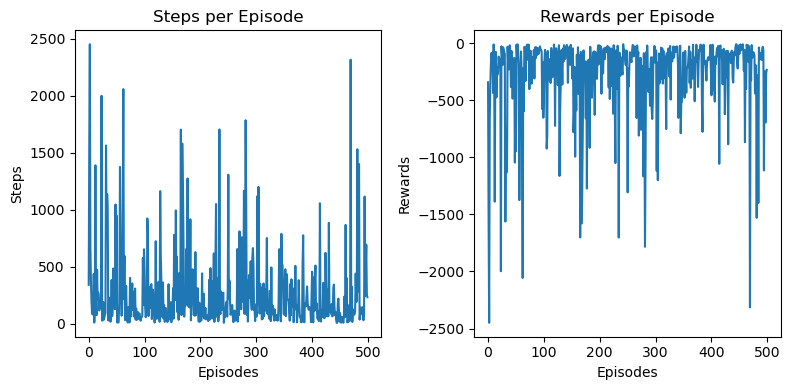

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Windy Grid World Environment (Continuous)
class WindyGridWorld:
    def __init__(self, rows, cols, wind_strength, start, goal):
        self.rows = rows
        self.cols = cols
        self.wind_strength = wind_strength
        self.start = np.array(start, dtype=float)
        self.goal = np.array(goal, dtype=float)
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Right, Down, Left, Up
        self.state = None

    def reset(self):
        self.state = self.start.copy()
        return self.discretize_state(self.state)

    def step(self, action):
        row, col = self.state
        d_row, d_col = self.actions[action]

        # Add noise to the step distance using normal distribution
        step_size_x = random.gauss(1, 0.33)
        step_size_y = random.gauss(1, 0.33)

        #step_size_x = random.gauss(1, 0.1)
        #step_size_y = random.gauss(1, 0.1)

        # Apply wind effect
        wind = self.wind_strength[int(col)]
        row += wind

        # Apply action with noise
        new_row = row + d_row * step_size_x
        new_col = col + d_col * step_size_y

        # Clamp position within grid
        new_row = max(0, min(self.rows - 1, new_row))
        new_col = max(0, min(self.cols - 1, new_col))

        self.state = np.array([new_row, new_col])
        reward = -1
        done = np.linalg.norm(self.state - self.goal) < 0.5  # Close enough to the goal
        return self.discretize_state(self.state), reward, done

    def discretize_state(self, state):
        return tuple(map(int, np.round(state)))

# Agent
class Agent:
    def __init__(self, env, alpha=0.5, epsilon=0.1, gamma=1.0):
        self.env = env
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.q_table = np.zeros((env.rows, env.cols, len(env.actions)))

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(len(self.env.actions))
        row, col = state
        return np.argmax(self.q_table[row, col])

    def update(self, state, action, reward, next_state):
        row, col = state
        next_row, next_col = next_state
        best_next_action = np.argmax(self.q_table[next_row, next_col])
        td_target = reward + self.gamma * self.q_table[next_row, next_col, best_next_action]
        td_error = td_target - self.q_table[row, col, action]
        self.q_table[row, col, action] += self.alpha * td_error

# Semi-Gradient SARSA Agent
class SemiGradientSARSA:
    def __init__(self, env, alpha=0.5, epsilon=0.1, gamma=1.0):
        self.env = env
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.theta = np.zeros((env.rows * env.cols * len(env.actions)))

    def features(self, state, action):
        row, col = state
        feature_vector = np.zeros(self.env.rows * self.env.cols * len(self.env.actions))
        index = (row * self.env.cols + col) * len(self.env.actions) + action
        feature_vector[index] = 1
        return feature_vector

    def q_value(self, state, action):
        return np.dot(self.theta, self.features(state, action))

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(len(self.env.actions))
        q_values = [self.q_value(state, a) for a in range(len(self.env.actions))]
        return np.argmax(q_values)

    def update(self, state, action, reward, next_state, next_action):
        current_q = self.q_value(state, action)
        next_q = self.q_value(next_state, next_action)
        td_error = reward + self.gamma * next_q - current_q
        self.theta += self.alpha * td_error * self.features(state, action)



# Testing and Visualization
def train(env, agent, episodes, sarsa=False):
    steps_per_episode = []
    rewards_per_episode = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        steps = 0
        action = agent.choose_action(state)

        while True:
            next_state, reward, done = env.step(action)
            next_action = agent.choose_action(next_state) if sarsa else None

            if sarsa:
                agent.update(state, action, reward, next_state, next_action)
            else:
                agent.update(state, action, reward, next_state)

            state = next_state
            action = next_action if sarsa else agent.choose_action(next_state)
            total_reward += reward
            steps += 1

            if done:
                break

        steps_per_episode.append(steps)
        rewards_per_episode.append(total_reward)

    return steps_per_episode, rewards_per_episode

def plot_results(steps, rewards, env, agent):
    # Plot Steps per Episode
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(steps)
    plt.xlabel('Episodes')
    plt.ylabel('Steps')
    plt.title('Steps per Episode')

    # Plot Rewards per Episode
    plt.subplot(1, 3, 2)
    plt.plot(rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.title('Rewards per Episode')

    plt.tight_layout()
    plt.show()

# Main
if __name__ == "__main__":
    rows, cols = 7, 10
    wind_strength = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
    start = (3, 0)
    goal = (3, 7)

    env = WindyGridWorld(rows, cols, wind_strength, start, goal)

    # Train Q-Learning Agent
    q_agent = Agent(env)
    episodes = 500
    steps_q, rewards_q = train(env, q_agent, episodes)

    # Train Semi-Gradient SARSA Agent
    sarsa_agent = SemiGradientSARSA(env)
    steps_sarsa, rewards_sarsa = train(env, sarsa_agent, episodes, sarsa=True)

    # Plot results for Q-Learning
    print("Results for Q-Learning:")
    plot_results(steps_q, rewards_q, env, q_agent)

    # Plot results for Semi-Gradient SARSA
    print("Results for Semi-Gradient SARSA:")
    plot_results(steps_sarsa, rewards_sarsa, env, sarsa_agent)



sg-Sarsa for Continuous Grid World with normal dsistribution (1,0.05) with different feature vectors (RBF, tilings, one hot encoding)

Results for Semi-Gradient SARSA with One-Hot Features:


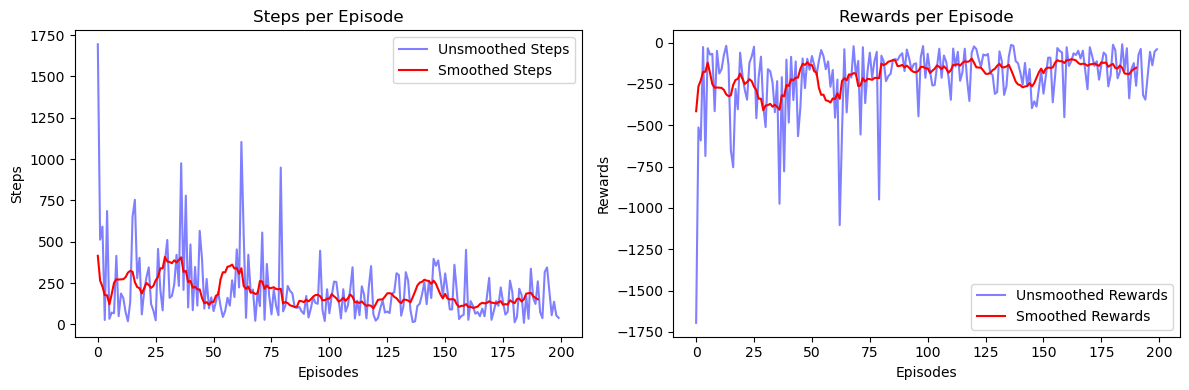

Results for Semi-Gradient SARSA with Tile Coding Features:


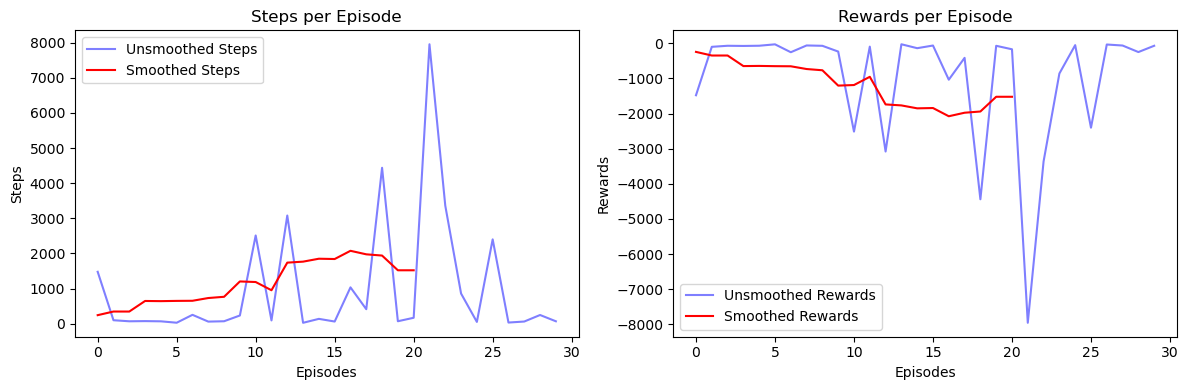

In [13]:
import numpy as np
import random
import matplotlib.pyplot as plt

# The WindyGridWorld class represents a grid world environment with wind effects.
class WindyGridWorld:
    def __init__(self, rows, cols, wind_strength, start, goal):
        # Initialize the grid dimensions, wind strength, start, and goal positions.
        self.rows = rows
        self.cols = cols
        self.wind_strength = wind_strength  # Wind strength per column
        self.start = np.array(start, dtype=float)  # Starting position (float for precision)
        self.goal = np.array(goal, dtype=float)  # Goal position
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Actions: Right, Down, Left, Up
        self.state = None  # Current state of the agent in the grid

    def reset(self):
        # Reset the environment to the starting position and return the initial state
        self.state = self.start.copy()
        return self.state

    def step(self, action):
        # Update the agent's position based on the chosen action and environment dynamics
        row, col = self.state
        d_row, d_col = self.actions[action]

        # Add noise to the step distance using normal distribution (introducing randomness in movement)
        step_size_x = random.gauss(1, 0.05)  # Random factor for row movement
        step_size_y = random.gauss(1, 0.05)  # Random factor for column movement

        # Apply wind effect based on the column position (wind strength varies by column)
        wind = self.wind_strength[int(col)]
        row += wind  # Modify the row position due to wind

        # Apply action with noise (effect of action and randomness)
        new_row = row + d_row * step_size_x
        new_col = col + d_col * step_size_y

        # Clamp the new position to stay within the grid boundaries
        new_row = max(0, min(self.rows - 1, new_row))
        new_col = max(0, min(self.cols - 1, new_col))

        self.state = np.array([new_row, new_col])  # Update state with the new position

        # The agent receives a constant reward of -1 until it reaches the goal
        reward = -1

        # The episode ends if the agent is within 0.5 units of the goal (close enough)
        done = np.linalg.norm(self.state - self.goal) < 0.5
        
        return self.state, reward, done  # Return the new state, reward, and done flag

# The SemiGradientSARSA class represents a SARSA (State-Action-Reward-State-Action) agent with semi-gradient updates.
class SemiGradientSARSA:
    def __init__(self, env, alpha=0.5, epsilon=0.1, gamma=1.0, feature_type="rbf", num_features=100):
        # Initialize the agent's parameters
        self.env = env  # The environment the agent will interact with
        self.alpha = alpha  # Learning rate
        self.epsilon = epsilon  # Exploration probability (epsilon-greedy)
        self.gamma = gamma  # Discount factor
        self.feature_type = feature_type  # Type of feature representation (rbf, one-hot, tile-coding)
        self.num_features = num_features  # Number of features in the feature vector
        self.theta = np.zeros(self.num_features)  # Initialize weights for the features
        self.num_tilings = 8  # For tile coding: the number of overlapping tilings
        self.tile_width = 1.0  # Width of each tile for tile coding

    # Function to compute Radial Basis Function (RBF) features for the given state-action pair
    def rbf_features(self, state, action, sigma=1.0):
        row, col = state
        # Create centers for the RBF features based on grid and actions
        centers = [(r, c, a) for r in np.linspace(0, self.env.rows - 1, 7) 
                                for c in np.linspace(0, self.env.cols - 1, 10) 
                                for a in range(len(self.env.actions))]
        feature_vector = np.zeros(self.num_features)

        # Calculate the Gaussian (RBF) feature values based on distance from the centers
        for i, (r, c, a) in enumerate(centers):
            distance = np.linalg.norm(np.array([row, col]) - np.array([r, c]))
            if i < len(feature_vector):
                feature_vector[i] = np.exp(-distance**2 / (2 * sigma**2)) if a == action else 0
        return feature_vector

    # One-hot encoding for state-action pairs (mapping state-action to a unique feature vector)
    def one_hot_features(self, state, action):
        """One-hot encoding for states and actions."""
        row, col = map(int, state)  # Convert state values to integers
        index = row * self.env.cols + col  # State index
        feature_vector = np.zeros(self.num_features)
        feature_vector[index * len(self.env.actions) + action] = 1  # Set the corresponding position to 1
        return feature_vector

    # Tile coding for continuous state-action spaces (discretizes the space using overlapping tiles)
    def tile_coding_features(self, state, action):
        """Tile coding for continuous state-action spaces."""
        row, col = state
        feature_vector = np.zeros(self.num_features)
        for tiling in range(self.num_tilings):
            # Offset each tiling to create overlapping tiles
            offset = (tiling / self.num_tilings) * self.tile_width
            tile_row = int((row + offset) // self.tile_width)
            tile_col = int((col + offset) // self.tile_width)
            index = (tile_row * self.env.cols + tile_col) * len(self.env.actions) + action
            index = index % self.num_features  # Ensure index doesn't exceed feature size
            feature_vector[index] = 1
        return feature_vector

    # Select the appropriate feature representation (based on the user's choice)
    def features(self, state, action):
        if self.feature_type == "rbf":
            return self.rbf_features(state, action)
        elif self.feature_type == "one_hot":
            return self.one_hot_features(state, action)
        elif self.feature_type == "tile_coding":
            return self.tile_coding_features(state, action)
        else:
            raise ValueError("Unsupported feature type")

    # Compute the Q-value (value of state-action pair) based on current weights and features
    def q_value(self, state, action):
        return np.dot(self.theta, self.features(state, action))

    # Choose an action using epsilon-greedy strategy
    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(len(self.env.actions))  # Exploration: choose random action
        q_values = [self.q_value(state, a) for a in range(len(self.env.actions))]  # Exploitation: choose best action
        return np.argmax(q_values)  # Return the action with the highest Q-value

    # Update the agent's parameters using the SARSA algorithm
    def update(self, state, action, reward, next_state, next_action):
        current_q = self.q_value(state, action)
        next_q = self.q_value(next_state, next_action) if next_action is not None else 0
        td_error = reward + self.gamma * next_q - current_q  # Temporal difference error
        self.theta += self.alpha * td_error * self.features(state, action)  # Update weights

# Function to train the agent with the environment
def train(env, agent, episodes, sarsa=False):
    steps_per_episode = []
    rewards_per_episode = []

    for episode in range(episodes):
        state = env.reset()  # Reset the environment at the beginning of each episode
        total_reward = 0  # Initialize total reward for the episode
        steps = 0  # Initialize the number of steps in the episode
        action = agent.choose_action(state)  # Choose the first action using epsilon-greedy

        while True:
            # Take the chosen action and get the next state, reward, and done flag
            next_state, reward, done = env.step(action)
            next_action = agent.choose_action(next_state) if sarsa else None

            # Update agent's knowledge (Q-values) based on the observed transition
            if sarsa:
                agent.update(state, action, reward, next_state, next_action)  # Update with SARSA
            else:
                agent.update(state, action, reward, next_state)  # Update with Q-learning (no next action)

            # Move to the next state and action for the next iteration
            state = next_state
            action = next_action if sarsa else agent.choose_action(next_state)

            total_reward += reward  # Accumulate total reward
            steps += 1  # Count the steps

            if done:
                break  # End the episode when goal is reached

        steps_per_episode.append(steps)  # Store the number of steps for the episode
        rewards_per_episode.append(total_reward)  # Store the total reward for the episode

    return steps_per_episode, rewards_per_episode  # Return the collected statistics

# Function to compute moving average (for smoothing the data)
def moving_average(data, window_size):
    """Calculates the moving average for the given data with the specified window size."""
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Function to plot the results of training (steps and rewards per episode)
def plot_results(steps, rewards, window_size=10):
    # Calculate moving averages for smoothing the data
    smoothed_steps = moving_average(steps, window_size)
    smoothed_rewards = moving_average(rewards, window_size)

    # Plot Steps per Episode
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(steps, color='blue', alpha=0.5, label='Unsmoothed Steps')  # Plot unsmoothed steps
    plt.plot(smoothed_steps, color='red', label='Smoothed Steps')  # Plot smoothed steps
    plt.xlabel('Episodes')
    plt.ylabel('Steps')
    plt.title('Steps per Episode')
    plt.legend()

    # Plot Rewards per Episode
    plt.subplot(1, 2, 2)
    plt.plot(rewards, color='blue', alpha=0.5, label='Unsmoothed Rewards')  # Plot unsmoothed rewards
    plt.plot(smoothed_rewards, color='red', label='Smoothed Rewards')  # Plot smoothed rewards
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.title('Rewards per Episode')
    plt.legend()

    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()

# Main function to run the code
if __name__ == "__main__":
    # Define grid world size, wind strength, start, and goal positions
    rows, cols = 7, 10
    wind_strength = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
    start = (3, 0)
    goal = (3, 7)

    # Create the Windy Grid World environment
    env = WindyGridWorld(rows, cols, wind_strength, start, goal)

    # One-Hot Encoding Feature Representation
    num_features_one_hot = rows * cols * len(env.actions)  # Number of features for one-hot encoding
    sarsa_agent_one_hot = SemiGradientSARSA(env, feature_type="one_hot", num_features=num_features_one_hot)
    steps_one_hot, rewards_one_hot = train(env, sarsa_agent_one_hot, episodes=200, sarsa=True)  # Train agent with SARSA
    print("Results for Semi-Gradient SARSA with One-Hot Features:")
    plot_results(steps_one_hot, rewards_one_hot)  # Plot results

    # Tile Coding Feature Representation
    num_tilings = 8  # Number of overlapping tilings for tile coding
    tile_width = 1.0  # Width of each tile
    num_features_tile = num_tilings * rows * cols * len(env.actions)  # Number of features for tile coding
    sarsa_agent_tile = SemiGradientSARSA(env, feature_type="tile_coding", num_features=num_features_tile)
    steps_tile, rewards_tile = train(env, sarsa_agent_tile, episodes=30, sarsa=True)  # Train agent with SARSA
    print("Results for Semi-Gradient SARSA with Tile Coding Features:")
    plot_results(steps_tile, rewards_tile)  # Plot results
